# Create various figures for the Dataset chapter of the Report

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os 
from PIL import Image
from pprint import pprint 
import cv2
import matplotlib.cm as cm
from matplotlib.colors import Normalize


In [2]:
import raster_relight as rr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import logging
logging.basicConfig(filename='dataset-figures.log', encoding='utf-8', level=logging.DEBUG)

In [63]:
chair_data_path = '/home/dtetruash/Thesis/datasets/nerf-blender/nerf_synthetic/chair_intrinsic/test'
ficus_data_path = '/home/dtetruash/Thesis/datasets/nerf-blender/nerf_synthetic/ficus_intrinsic/test'

figures_dir = '/home/dtetruash/Thesis/report/figures/dataset'

In [18]:
downsample_ratio = 4 # gives 200x200 images

In [19]:
# Load in the dataset as images
def load_images(image_number, data_path, depth_scale=1/8, depth_trunc=8.0, downsample_ratio=downsample_ratio):
    """ Load images into (W, H, 3) ndarrays.
    """
    image_paths = rr.get_image_paths(image_number, data_path, channels=['normal', 'albedo', 'depth', 'diffuse', 'illumination'])

    # Load image data all as ND arrays
    images = {}
    for channel, path in image_paths.items():
        logging.info(f"Loading {channel} from {path}.")
        try:
            if channel in ['normal']:
                image = rr.read_16bit(path)
            else:
                image = np.asarray(Image.open(path))

            images[channel] = image
        except ValueError:
            print(f"The necessary image channel pass '{channel}' for image '{image_number}' was not found at expeced location {path}")
            raise

    # FIXME: Find a better way to get the W/H
    W, H = np.asarray(list(images.items())[0][1]).shape[:-1]

    # apply downscaling if needed
    if downsample_ratio > 1:
        W, H = W//downsample_ratio, H//downsample_ratio

        downsampled_images = {}
        for channel, image in images.items():
            downsampled_images[channel] = cv2.resize(image, (W, H), interpolation=cv2.INTER_AREA)

        images = downsampled_images

    # get only the alpha from the depth image
    depth_alpha = images['depth'][..., -1]  # This would be an array in [0,255]

    logging.debug(f"Got depth_alpha from {depth_alpha.min()} to {depth_alpha.max()} with mean of {depth_alpha.mean()}. The datatype is { depth_alpha.dtype }")

    # plt.imsave('depth_alpha.png', depth_alpha, vmin=0, vmax=255, cmap='gray')

    # invert the depth image to be black -> white as depth increases
    depth_remapped, depth_normalization_constant = rr.remap_depth_black2white(depth_alpha)
    images['depth_remapped'] = np.broadcast_to(depth_remapped[..., np.newaxis], (W,H,4))

    # Normalize depth to [0,1] after the rgbd image is created
    depth_normalized = depth_remapped / depth_normalization_constant
    logging.debug(f"After normalizing got depth_normalized from {depth_normalized.min()} to {depth_normalized.max()} with mean of {depth_normalized.mean()}. The datatype is { depth_normalized.dtype }")

    # get image occupancy
    occupancy_mask = rr.get_occupancy(depth_alpha)

    # return image data (minux alpha) for only occupied pixels for further processing
    
    return W, H, images, occupancy_mask


## Figure 1: Dataset overview. A grid of samples in order from chair and ficus scenes

In [20]:
W, H, images, occupancy_mask = load_images(1, chair_data_path)

In [21]:
print("images loaded were:")
pprint({image_name: (image.shape, image.dtype) for image_name, image in images.items()})

images loaded were:
{'albedo': ((200, 200, 4), dtype('uint8')),
 'depth': ((200, 200, 4), dtype('uint8')),
 'depth_remapped': ((200, 200, 4), dtype('uint8')),
 'diffuse': ((200, 200, 4), dtype('uint8')),
 'ground_truth': ((200, 200, 4), dtype('uint8')),
 'illumination': ((200, 200, 4), dtype('uint8')),
 'normal': ((200, 200, 4), dtype('uint8'))}


In [22]:
def stack_images(images):
    ordering = ['ground_truth', 'diffuse', 'albedo', 'illumination', 'normal', 'depth_remapped']
    return np.concatenate([images[name] for name in ordering])

In [51]:
def depth_to_color(data_array, alpha, cmap_name='viridis'):
    cmap = matplotlib.colormaps[cmap_name]
    norm = Normalize(vmin=data_array.min(), vmax=data_array.max())
    rgba_values = cmap(norm(data_array))
    rgba_values[..., -1] = alpha.astype(np.uint8)
    return (rgba_values * 255).astype(np.uint8)
 

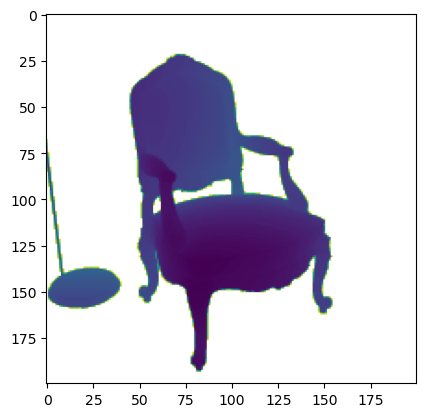

In [54]:
plt.imshow(depth_to_color(images['depth_remapped'][...,-1], occupancy_mask))

In [27]:
# choose image/frame numbers
rng = np.random.default_rng()

In [35]:
image_numbers = np.linspace(0,140,num=12,dtype=np.uint8)
image_numbers

array([  0,  12,  25,  38,  50,  63,  76,  89, 101, 114, 127, 140],
      dtype=uint8)

In [58]:
def create_overview_figure(image_numbers, data_path):
    image_list = []
    for image_number in image_numbers:
        _, _, images, occupancy_mask = load_images(image_number, data_path)
        images['depth_remapped'] = depth_to_color(images['depth_remapped'][...,-1], occupancy_mask)
        #images['depth_remapped'] = images['depth_remapped'] * 255
        image_list.append(stack_images(images))

    return Image.fromarray(np.concatenate(image_list, axis=1), 'RGBA')

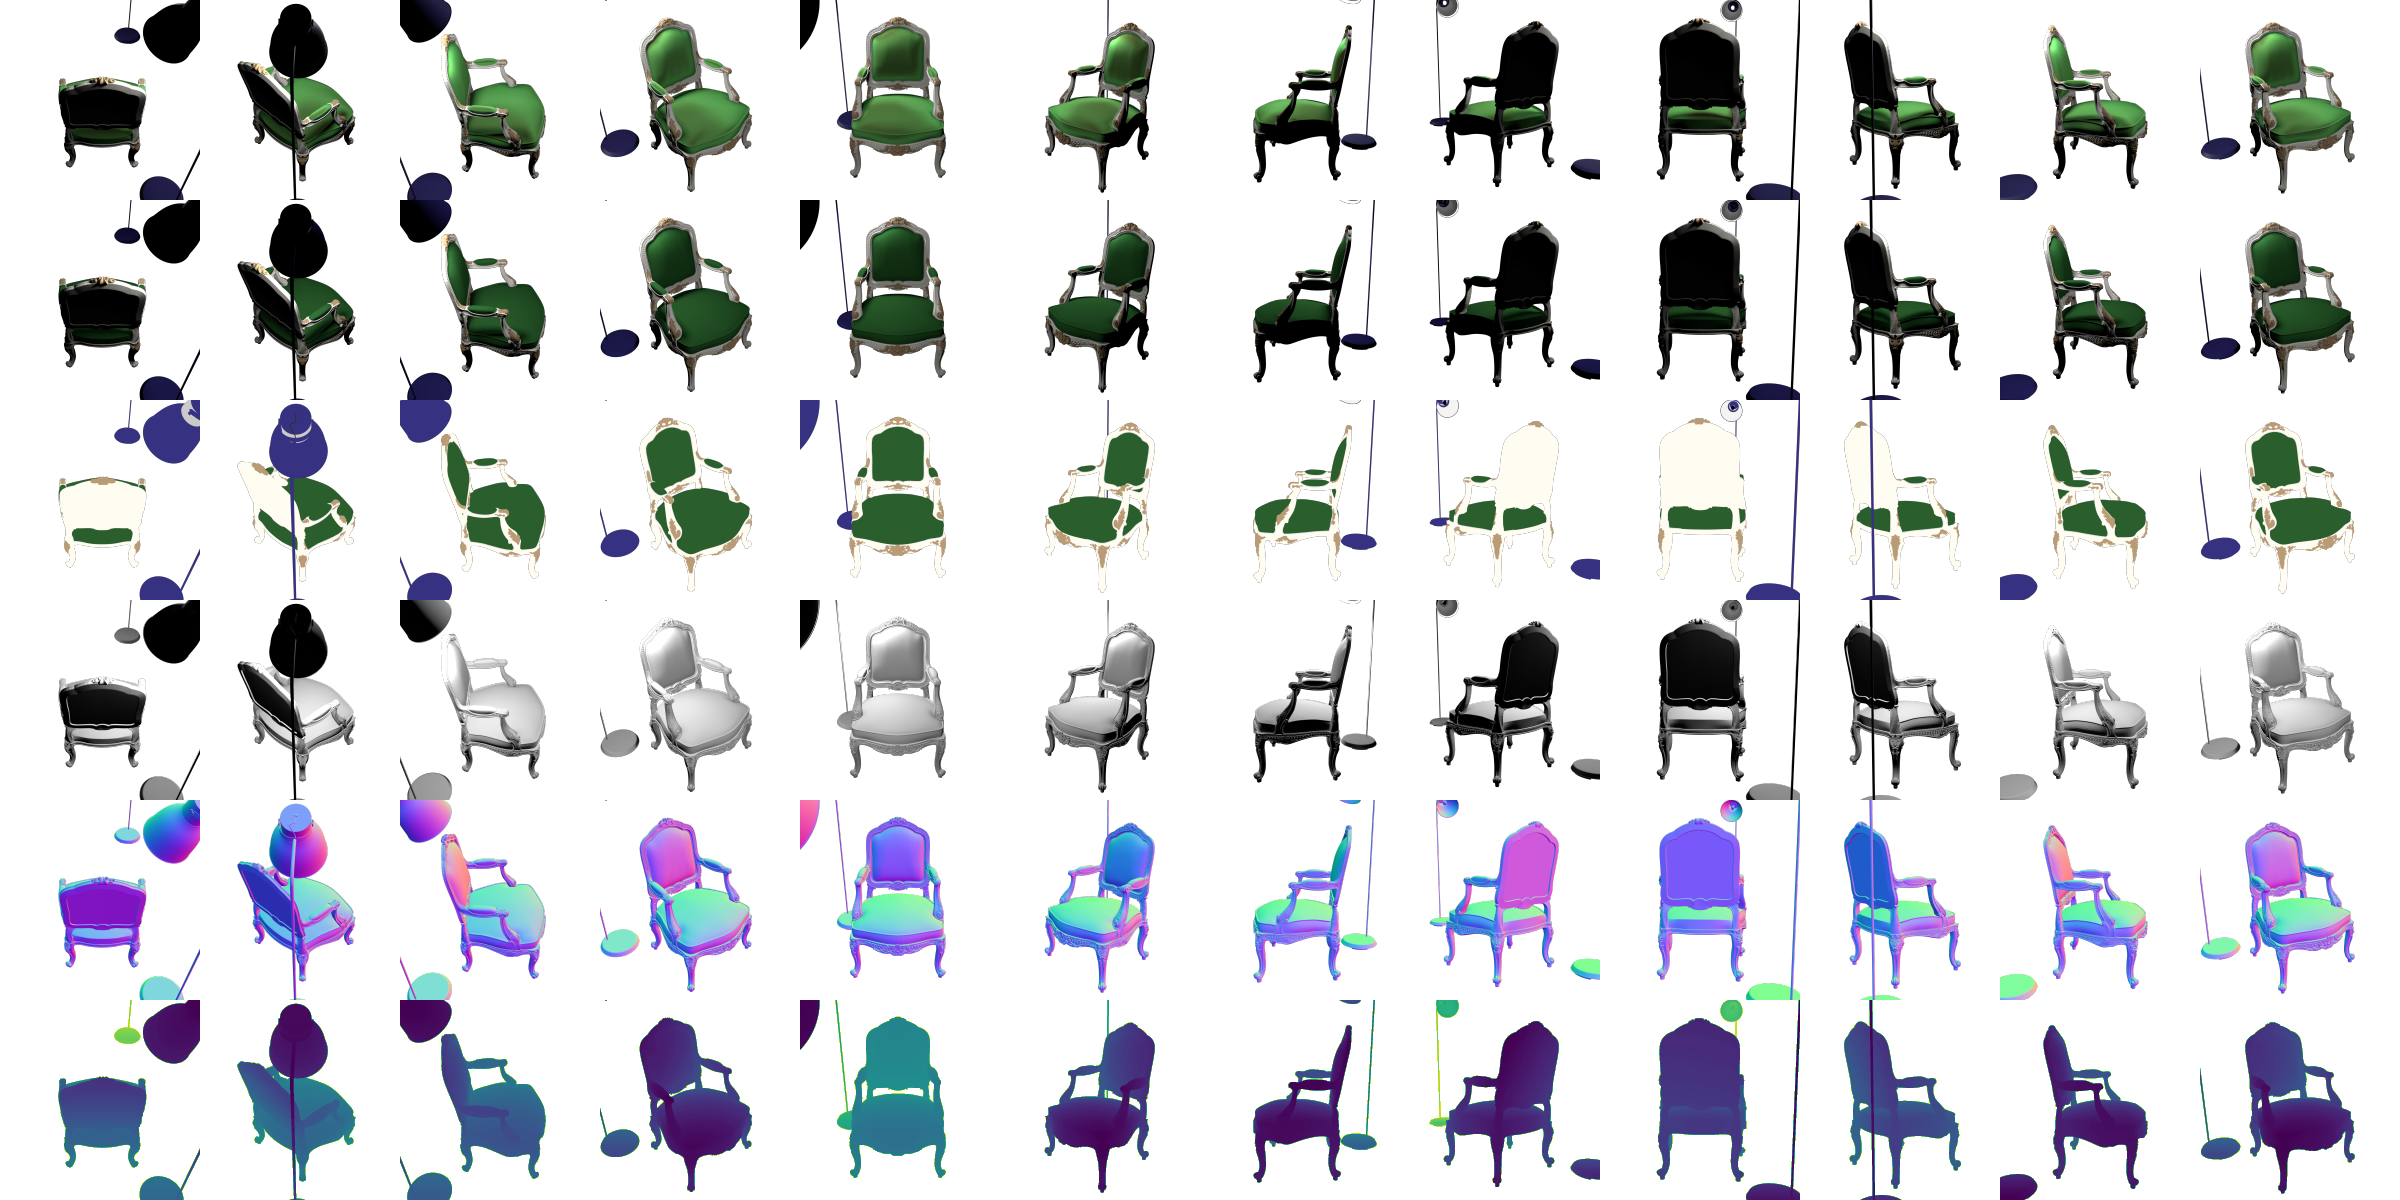

In [64]:
dataset_overview_chair_figure = create_overview_figure(image_numbers, chair_data_path)
dataset_overview_chair_figure.save(f"{figures_dir}/dataset_overview_chair.png")
dataset_overview_chair_figure

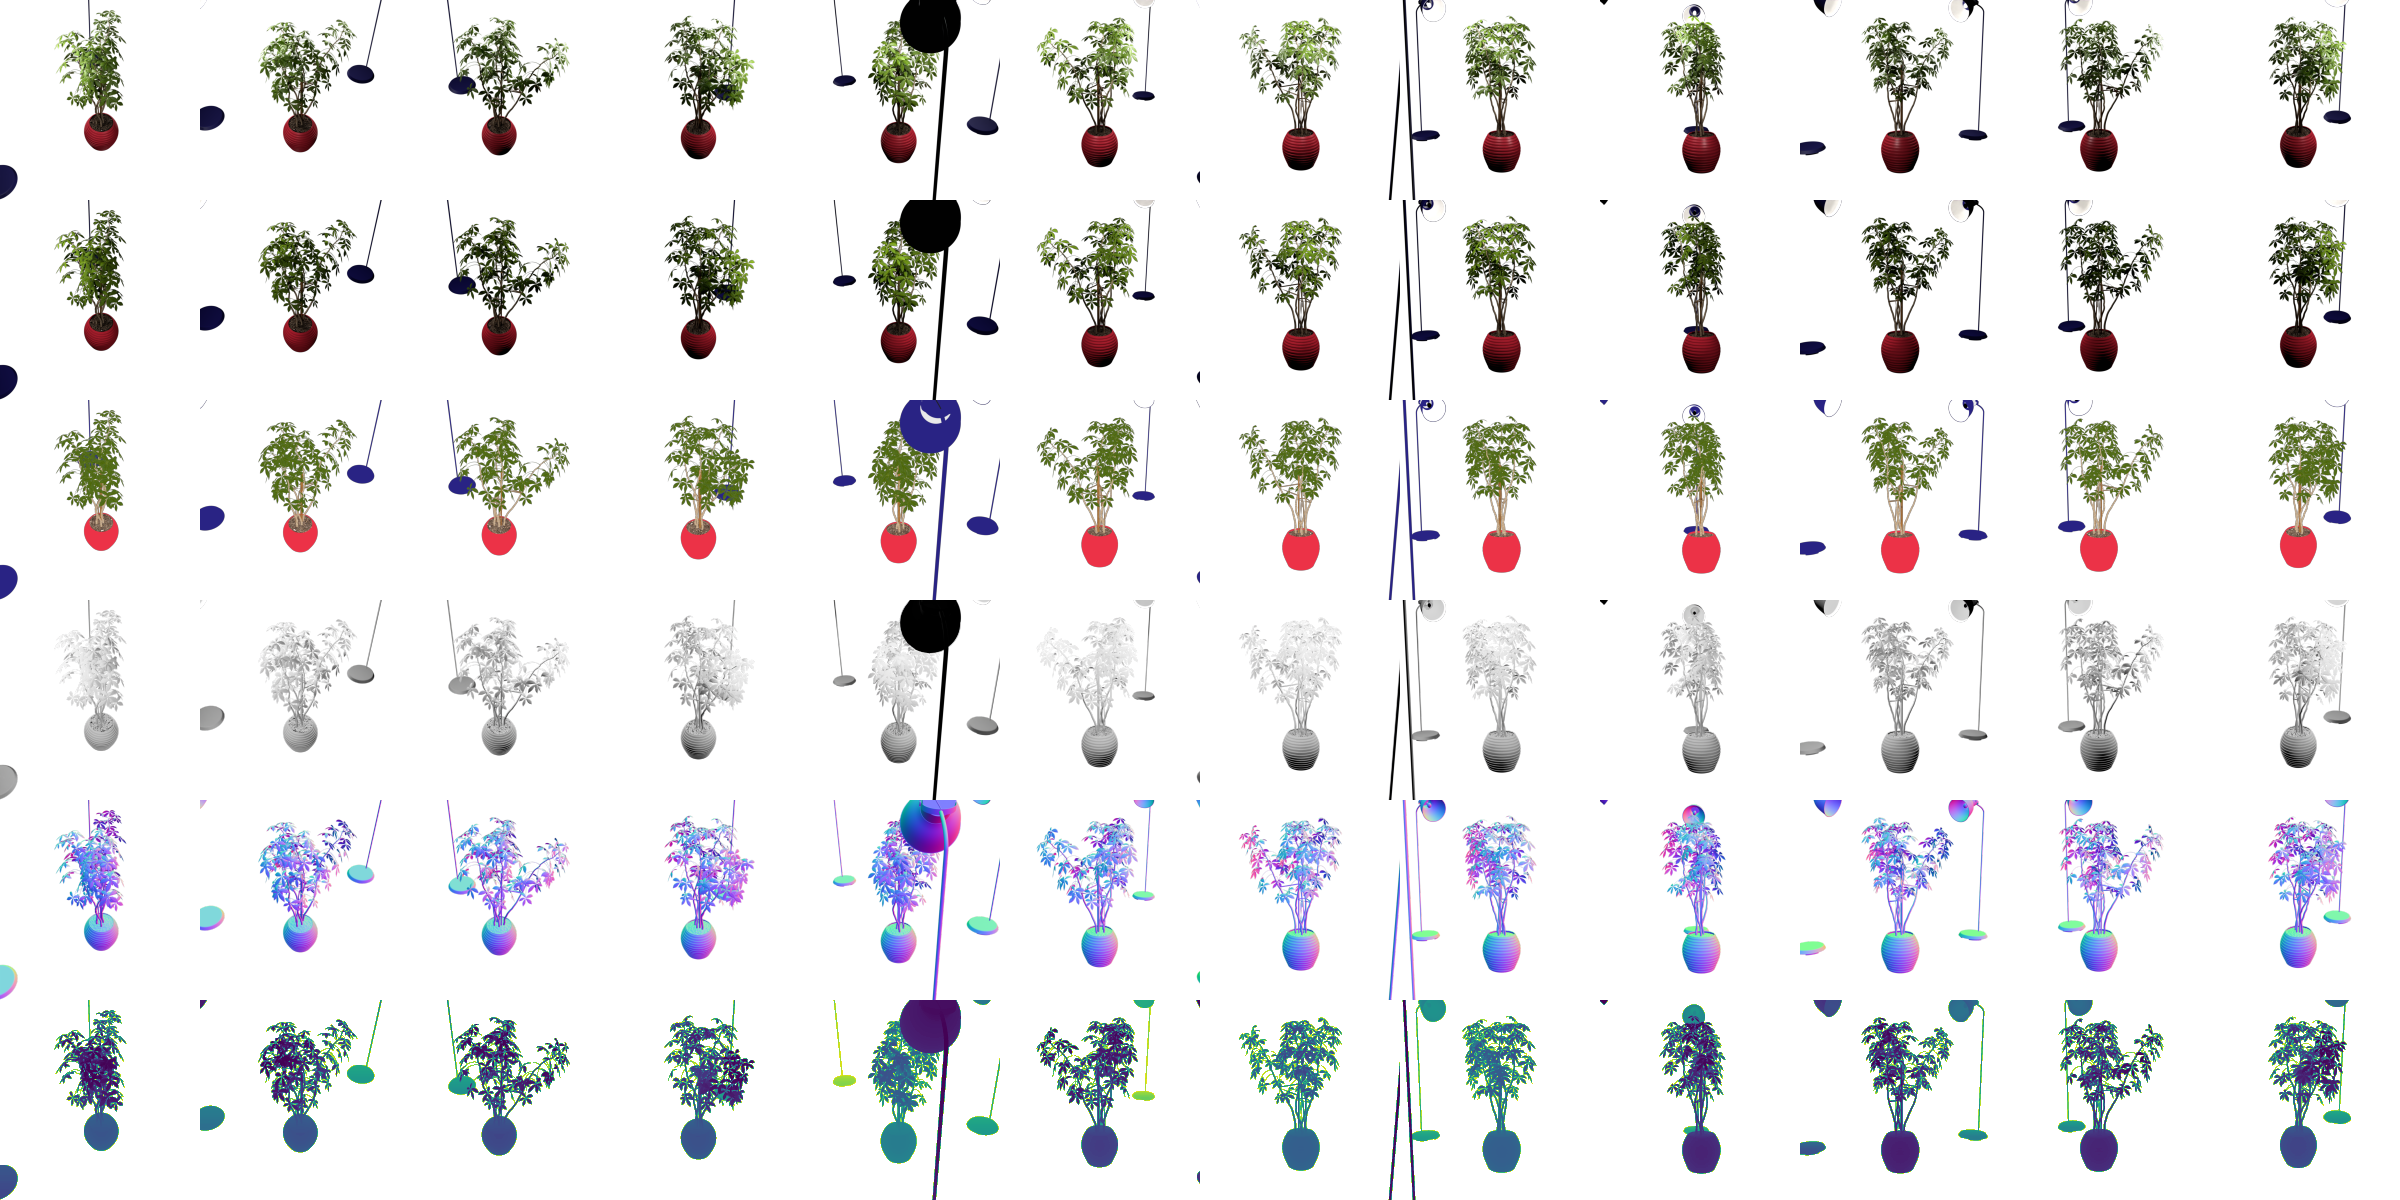

In [65]:
dataset_overview_ficus_figure = create_overview_figure(image_numbers, ficus_data_path)
dataset_overview_ficus_figure.save(f"{figures_dir}/dataset_overview_ficus.png")
dataset_overview_ficus_figure